#MSc Project
**Title :** Pattern Recognition Approaches for Identifying and predicting Stock Market next-day Returns, Close price and Up/Down <br>

**Name:** Deboky Saha <br>
**Student ID:** 001142694 <br>
**Supervisor:** Georgios Samakovitis <br>
**Second Marker:** Christopher Walshaw


**This part of the code is for the implementation of merged stock data with 15 stocks**


First the important libaries is imported. To install the Yahoo Finance library for stock several steps are taken.

In [ ]:
!pip install yfinance


     |████████████████████████████████| 6.4 MB 7.4 MB/s 
     |████████████████████████████████| 63 kB 939 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
# Importing Libraries
# DataFrame library
import pandas as pd

# Yahoo Finance library
import yfinance as yf
import pandas_datareader as web

# Datetime library
import datetime as dt

# Visualisation library
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-processing library
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from feature_engine.encoding import OneHotEncoder 

# LSTM Model

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout


### Calculate performance metrics
import math 
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
#Downloading 15 stocks from Yahoo Finance
tickers_list = ['III.L','BARC.L','BT-A.L','BRBY.L','HSBA.L','LLOY.L','SBRY.L','WPP.L','TSCO.L','EXPN.L','NANO.L','TCS.L','BP.L','DGE.L','ABD.L']
Stock_Data = yf.download(tickers_list, data_source='yahoo',start='2015-01-01', end='2020-01-01')
print(Stock_Data.head())




[*********************100%***********************]  15 of 15 completed
             Adj Close              ...       Volume           
                 ABD.L      BARC.L  ...       TSCO.L      WPP.L
Date                                ...                        
2015-01-02  156.210251  201.714691  ...   14473912.0  1759714.0
2015-01-05  155.117889  194.704651  ...   24127306.0  4259770.0
2015-01-06  154.680923  191.095963  ...   21147845.0  4044089.0
2015-01-07  156.428726  191.303391  ...   24585173.0  4010417.0
2015-01-08  158.845474  196.654205  ...  119768830.0  3849047.0

[5 rows x 90 columns]


In [ ]:
# Viewing the entire dataset
Stock_Data

Adj Close              ...       Volume           
                 ABD.L      BARC.L  ...       TSCO.L      WPP.L
Date                                ...                        
2015-01-02  156.210251  201.714691  ...   14473912.0  1759714.0
2015-01-05  155.117889  194.704651  ...   24127306.0  4259770.0
2015-01-06  154.680923  191.095963  ...   21147845.0  4044089.0
2015-01-07  156.428726  191.303391  ...   24585173.0  4010417.0
2015-01-08  158.845474  196.654205  ...  119768830.0  3849047.0
...                ...         ...  ...          ...        ...
2019-12-24  249.519547  170.588272  ...    1943484.0   487545.0
2019-12-26         NaN         NaN  ...          NaN        NaN
2019-12-27  246.618179  172.009842  ...    7381457.0  1432396.0
2019-12-30  250.970245  170.815735  ...    8904844.0  1588679.0
2019-12-31  249.519547  170.247101  ...    6405384.0   826644.0

[1284 rows x 90 columns]

In [ ]:
# Takes 38s to run
total_rows = Stock_Data.shape[0]
print(total_rows)

# Columns of new dataframe- Date, Symbol, Adj Close, Volume, Open,Close,High,Low
data_list = []

column_list = Stock_Data['Adj Close'].columns
#print(column_list)

for index in range(0, total_rows):
    for column_val in column_list:
        data_list.append([Stock_Data.index[index].date(), column_val, Stock_Data['Adj Close'][column_val][index], Stock_Data['Volume'][column_val][index], Stock_Data['Open'][column_val][index], Stock_Data['Close'][column_val][index], Stock_Data['High'][column_val][index], Stock_Data['Low'][column_val][index]])

new_dataframe_FifteenStocks = pd.DataFrame(data_list, columns = ['Date','Symbol','Adj Close','Volume', 'Open', 'Close', 'High', 'Low'])
print(new_dataframe_FifteenStocks)

1284
             Date  Symbol    Adj Close  ...        Close         High          Low
0      2015-01-02   ABD.L   156.210251  ...   178.750000   179.557999   178.000000
1      2015-01-02  BARC.L   201.714691  ...   243.149994   245.600006   241.550003
2      2015-01-02    BP.L   261.981781  ...   410.450012   415.649994   404.149994
3      2015-01-02  BRBY.L  1397.968628  ...  1624.000000  1651.560059  1620.000000
4      2015-01-02  BT-A.L   303.599884  ...   401.000000   404.299988   398.399994
...           ...     ...          ...  ...          ...          ...          ...
19255  2019-12-31  NANO.L    13.500000  ...    13.500000    13.900000    13.500000
19256  2019-12-31  SBRY.L   213.266968  ...   229.899994   235.809998   229.899994
19257  2019-12-31   TCS.L    20.535049  ...    21.500000    21.500000    21.100000
19258  2019-12-31  TSCO.L   248.376572  ...   323.253204   325.621796   321.099792
19259  2019-12-31   WPP.L   966.022400  ...  1066.500000  1076.000000  1060.500000

In [ ]:
new_dataframe_FifteenStocks

,Date,Symbol,Adj Close,Volume,Open,Close,High,Low
0,2015-01-02,ABD.L,156.210251,34441.0,178.000000,178.750000,179.557999,178.000000
1,2015-01-02,BARC.L,201.714691,20219711.0,242.199997,243.149994,245.600006,241.550003
2,2015-01-02,BP.L,261.981781,19207206.0,413.950012,410.450012,415.649994,404.149994
3,2015-01-02,BRBY.L,1397.968628,1021764.0,1650.000000,1624.000000,1651.560059,1620.000000
4,2015-01-02,BT-A.L,303.599884,6228506.0,403.600006,401.000000,404.299988,398.399994
...,...,...,...,...,...,...,...,...
19255,2019-12-31,NANO.L,13.500000,67628.0,13.500000,13.500000,13.900000,13.500000
19256,2019-12-31,SBRY.L,213.266968,1994680.0,234.199997,229.899994,235.809998,229.899994
19257,2019-12-31,TCS.L,20.535049,76140.0,21.250000,21.500000,21.500000,21.100000
19258,2019-12-31,TSCO.L,248.376572,6405384.0,322.746490,323.253204,325.621796,321.099792


**Computing Returns**

In [ ]:
new_dataframe_FifteenStocks['Daily_returns'] = new_dataframe_FifteenStocks['Adj Close'].pct_change()


**Computing next day returns**

In [ ]:
new_dataframe_FifteenStocks['Output_NextClose'] = new_dataframe_FifteenStocks['Close'].shift(1)

**Calculating the next day returns**

In [ ]:
new_dataframe_FifteenStocks['Output_NextReturns'] = new_dataframe_FifteenStocks['Daily_returns'].shift(1)

**Computing Up/Down**

In [ ]:
new_dataframe_FifteenStocks['Output_Up_Down'] = 0
for i in range(new_dataframe_FifteenStocks.shape[0]-1):
  if (new_dataframe_FifteenStocks['Close'][i+1]>new_dataframe_FifteenStocks['Close'][i]):
    new_dataframe_FifteenStocks['Output_Up_Down'][i+1] = 1 #Up
  else:
    new_dataframe_FifteenStocks['Output_Up_Down'][i+1] = 0 #Down


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#Data Pre-processing

**Checking the missing values and resolving the issues**

In [ ]:
Nan_Data = new_dataframe_FifteenStocks[new_dataframe_FifteenStocks.isnull().any(axis=1)]
Nan_Data

,Date,Symbol,Adj Close,Volume,Open,Close,High,Low,Daily_returns,Output_NextReturns,Output_Up_Down,Output_NextClose
0,2015-01-02,ABD.L,156.210251,34441.0,178.000000,178.750000,179.557999,178.000000,NaN,NaN,0,NaN
1,2015-01-02,BARC.L,201.714691,20219711.0,242.199997,243.149994,245.600006,241.550003,0.291303,NaN,1,178.750000
177,2015-01-19,TCS.L,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.861778,0,257.500000
178,2015-01-19,TSCO.L,204.981781,28563336.0,282.909790,280.439789,287.723206,279.426514,0.068932,0.000000,0,NaN
477,2015-02-16,TCS.L,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.881672,0,267.200012
...,...,...,...,...,...,...,...,...,...,...,...,...
19211,2019-12-26,SBRY.L,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0,NaN
19212,2019-12-26,TCS.L,19.961977,0.0,20.900000,20.900000,20.900000,20.900000,-0.979384,0.000000,0,NaN
19213,2019-12-26,TSCO.L,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-0.979384,0,20.900000
19214,2019-12-26,WPP.L,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0,NaN


**When filling the missing values, Data and Symbol cannot be filled as these are not numerical value. Thus a smaller dataset is used.**

In [ ]:
DataFrame_Smaller = new_dataframe_FifteenStocks[['Adj Close','Volume','Open','Close','High','Low','Daily_returns','Output_NextReturns','Output_NextClose','Output_Up_Down']]


**KNN Imputer is being to filled the missing values**

In [ ]:
from sklearn.impute import KNNImputer

impute_missing_knn = KNNImputer(n_neighbors=5)
Data_FifteenStocks_Filling = pd.DataFrame(impute_missing_knn.fit_transform(DataFrame_Smaller))

In [ ]:
Data_FifteenStocks_Filling

,0,1,2,3,4,5,6,7,8,9
0,156.210251,34441.0,178.000000,178.750000,179.557999,178.000000,0.000000,0.000000,103.524003,0.0
1,201.714691,20219711.0,242.199997,243.149994,245.600006,241.550003,0.291303,0.000000,178.750000,1.0
2,261.981781,19207206.0,413.950012,410.450012,415.649994,404.149994,0.298774,0.291303,243.149994,1.0
3,1397.968628,1021764.0,1650.000000,1624.000000,1651.560059,1620.000000,4.336129,0.298774,410.450012,1.0
4,303.599884,6228506.0,403.600006,401.000000,404.299988,398.399994,-0.782828,4.336129,1624.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
19255,13.500000,67628.0,13.500000,13.500000,13.900000,13.500000,-0.759844,-0.945279,62.500000,0.0
19256,213.266968,1994680.0,234.199997,229.899994,235.809998,229.899994,14.797553,-0.759844,13.500000,1.0
19257,20.535049,76140.0,21.250000,21.500000,21.500000,21.100000,-0.903712,14.797553,229.899994,0.0
19258,248.376572,6405384.0,322.746490,323.253204,325.621796,321.099792,11.095251,-0.903712,21.500000,1.0


**The filled values corresopond to which columns are mentioned**

In [ ]:
Attributes = ['Adj Close','Volume','Open','Close','High','Low','Daily_returns','Output_NextReturns','Output_NextClose','Output_Up_Down']
DataFrame_FifteenStocks_Updated = pd.DataFrame(Data_FifteenStocks_Filling.values,columns=Attributes)

In [ ]:
DataFrame_FifteenStocks_Updated

,Adj Close,Volume,Open,Close,High,Low,Daily_returns,Output_NextReturns,Output_NextClose,Output_Up_Down
0,156.210251,34441.0,178.000000,178.750000,179.557999,178.000000,0.000000,0.000000,103.524003,0.0
1,201.714691,20219711.0,242.199997,243.149994,245.600006,241.550003,0.291303,0.000000,178.750000,1.0
2,261.981781,19207206.0,413.950012,410.450012,415.649994,404.149994,0.298774,0.291303,243.149994,1.0
3,1397.968628,1021764.0,1650.000000,1624.000000,1651.560059,1620.000000,4.336129,0.298774,410.450012,1.0
4,303.599884,6228506.0,403.600006,401.000000,404.299988,398.399994,-0.782828,4.336129,1624.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
19255,13.500000,67628.0,13.500000,13.500000,13.900000,13.500000,-0.759844,-0.945279,62.500000,0.0
19256,213.266968,1994680.0,234.199997,229.899994,235.809998,229.899994,14.797553,-0.759844,13.500000,1.0
19257,20.535049,76140.0,21.250000,21.500000,21.500000,21.100000,-0.903712,14.797553,229.899994,0.0
19258,248.376572,6405384.0,322.746490,323.253204,325.621796,321.099792,11.095251,-0.903712,21.500000,1.0


**Viewing the correlations**

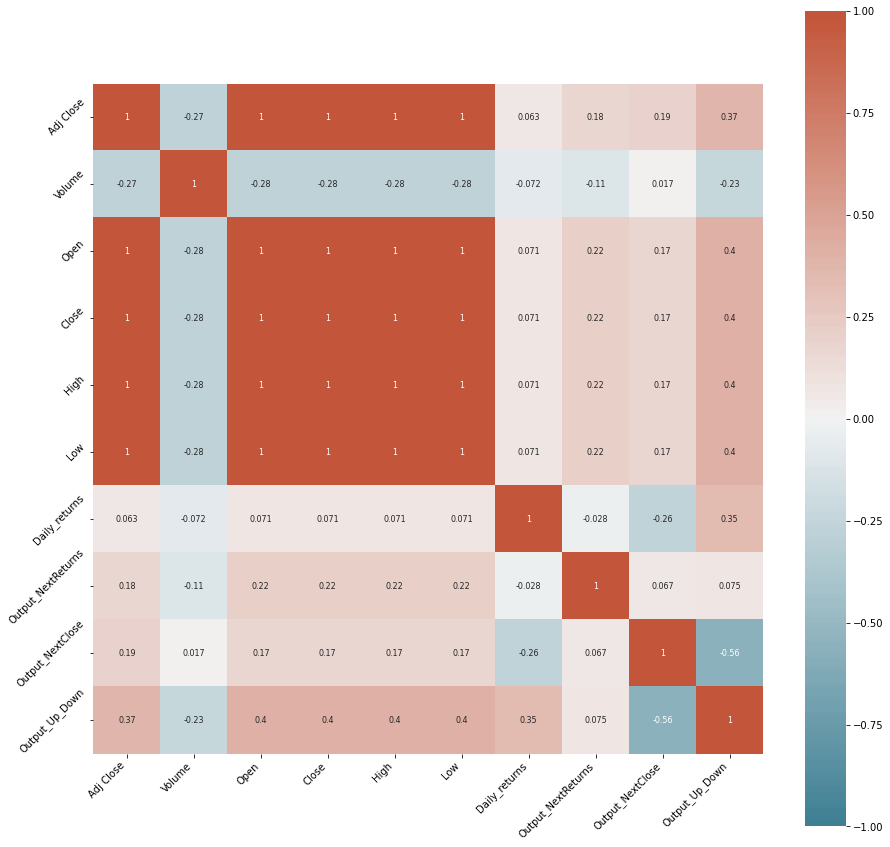

In [ ]:
plt.figure(figsize=(15, 15))
corr = DataFrame_FifteenStocks_Updated.corr()
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(220, 20, n=200), square=True, annot=True,
                 annot_kws={"size": 8})
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=45, horizontalalignment='right')

plt.show()

In [ ]:
Extracted_Column = new_dataframe_FifteenStocks['Symbol']
Extracted_Column
DataFrame_FifteenStocks_Updated_WithSymbols = DataFrame_FifteenStocks_Updated.join(Extracted_Column, how='left')

In [ ]:
DataFrame_FifteenStocks_Updated_WithSymbols

,Adj Close,Volume,Open,Close,High,Low,Daily_returns,Output_NextReturns,Output_NextClose,Output_Up_Down,Symbol
0,156.210251,34441.0,178.000000,178.750000,179.557999,178.000000,0.000000,0.000000,103.524003,0.0,ABD.L
1,201.714691,20219711.0,242.199997,243.149994,245.600006,241.550003,0.291303,0.000000,178.750000,1.0,BARC.L
2,261.981781,19207206.0,413.950012,410.450012,415.649994,404.149994,0.298774,0.291303,243.149994,1.0,BP.L
3,1397.968628,1021764.0,1650.000000,1624.000000,1651.560059,1620.000000,4.336129,0.298774,410.450012,1.0,BRBY.L
4,303.599884,6228506.0,403.600006,401.000000,404.299988,398.399994,-0.782828,4.336129,1624.000000,0.0,BT-A.L
...,...,...,...,...,...,...,...,...,...,...,...
19255,13.500000,67628.0,13.500000,13.500000,13.900000,13.500000,-0.759844,-0.945279,62.500000,0.0,NANO.L
19256,213.266968,1994680.0,234.199997,229.899994,235.809998,229.899994,14.797553,-0.759844,13.500000,1.0,SBRY.L
19257,20.535049,76140.0,21.250000,21.500000,21.500000,21.100000,-0.903712,14.797553,229.899994,0.0,TCS.L
19258,248.376572,6405384.0,322.746490,323.253204,325.621796,321.099792,11.095251,-0.903712,21.500000,1.0,TSCO.L


In [ ]:
!pip install feature-engine

     |████████████████████████████████| 205 kB 5.6 MB/s 
     |████████████████████████████████| 9.8 MB 49.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
#Finding the unique symbols
DataFrame_FifteenStocks_Updated_WithSymbols['Symbol'].unique()

array(['ABD.L', 'BARC.L', 'BP.L', 'BRBY.L', 'BT-A.L', 'DGE.L', 'EXPN.L',
       'HSBA.L', 'III.L', 'LLOY.L', 'NANO.L', 'SBRY.L', 'TCS.L', 'TSCO.L',
       'WPP.L'], dtype=object)

**Splitting the dataset**

In [ ]:
from sklearn.model_selection import train_test_split


Input_Features = ['Adj Close','Volume','Daily_returns','Symbol']

# Three outputs are Up/Down, Next Day closing price and next day returns
Y_UD = DataFrame_FifteenStocks_Updated_WithSymbols['Output_Up_Down']
Y_CP = DataFrame_FifteenStocks_Updated_WithSymbols['Output_NextClose']
Y_R =  DataFrame_FifteenStocks_Updated_WithSymbols['Output_NextReturns']
X = DataFrame_FifteenStocks_Updated_WithSymbols[Input_Features]


X.head()


,Adj Close,Volume,Daily_returns,Symbol
0,156.210251,34441.0,0.000000,ABD.L
1,201.714691,20219711.0,0.291303,BARC.L
2,261.981781,19207206.0,0.298774,BP.L
3,1397.968628,1021764.0,4.336129,BRBY.L
4,303.599884,6228506.0,-0.782828,BT-A.L


In [ ]:
X_Train_CP, X_Val_CP, y_Train_Output_CP, y_Val_Output_CP= train_test_split(X,Y_CP,test_size = 0.20,shuffle=False)
# Two outputs are there in the LSTM 

**Performing one hot encoding**

In [ ]:
# # to split the Dataset
# from sklearn.model_selection import train_test_split

from feature_engine.encoding import OneHotEncoder 

Encoding_Symbols = OneHotEncoder(
    top_categories=10,  # you can change this value to select more or less variables
    # we can select which variables to encode
    variables=['Symbol'],
    drop_last=False)

Encoding_Symbols.fit(X_Train_CP)




OneHotEncoder(top_categories=10, variables=['Symbol'])

In [ ]:

X_train_CP1 = Encoding_Symbols.transform(X_Train_CP)
X_test_CP1 = Encoding_Symbols.transform(X_Val_CP)

# let's explore the result
X_train_CP1.head()

,Adj Close,Volume,Daily_returns,Symbol_BARC.L,Symbol_ABD.L,Symbol_BP.L,Symbol_LLOY.L,Symbol_WPP.L,Symbol_TCS.L,Symbol_EXPN.L,Symbol_DGE.L,Symbol_BT-A.L,Symbol_SBRY.L
0,156.210251,34441.0,0.000000,0,1,0,0,0,0,0,0,0,0
1,201.714691,20219711.0,0.291303,1,0,0,0,0,0,0,0,0,0
2,261.981781,19207206.0,0.298774,0,0,1,0,0,0,0,0,0,0
3,1397.968628,1021764.0,4.336129,0,0,0,0,0,0,0,0,0,0
4,303.599884,6228506.0,-0.782828,0,0,0,0,0,0,0,0,1,0


In [ ]:
y_Train_Output_CP.head()

0     103.524003
1     178.750000
2     243.149994
3     410.450012
4    1624.000000
Name: Output_NextClose, dtype: float64

**Box-Cox Transformation will be used for this project as it resembles normal distribution which is important in time series analysis.**




In [ ]:
from sklearn.preprocessing import PowerTransformer


Power_Transformer_For_Stock_X = PowerTransformer() # Different features are in different scale and thus bringing them in one scale is crucial
Power_Transformer_For_Stock_y = PowerTransformer() # Output1 is the price and has thus it needs to come to a certain scale

#Transforming the training input dataset 
X_Train_CP_PT = Power_Transformer_For_Stock_X.fit_transform(X_train_CP1)

#Transforming the validation input dataset 
X_Val_CP_PT = Power_Transformer_For_Stock_X.fit_transform(X_test_CP1)


#Transforming the training output dataset 
y_Train_reshape = y_Train_Output_CP.values.reshape(-1, 1)
y_Train_Output_PT = Power_Transformer_For_Stock_y.fit_transform(y_Train_reshape)


#Transforming the validation output dataset 
y_Val_Output_reshape = y_Val_Output_CP.values.reshape(-1, 1)
y_Val_Output_PT = Power_Transformer_For_Stock_y.fit_transform(y_Val_Output_reshape)





#LSTM Model

In [ ]:


X_Train_LSTM_reshape = X_Train_CP_PT.reshape(-1, 1, 13) # 13 input features from which 10 is the result of one hot encoding of 10 ticker symbol
X_Val_LSTM_reshape  = X_Val_CP_PT.reshape(-1, 1, 13) # 13 input features from which 10 is the result of one hot encoding of 10 ticker symbol
y_Train_Output_LSTM_reshape = y_Train_Output_PT.reshape(-1, 1, 1) # The output has two values
y_Val_Output_LSTM_reshape = y_Val_Output_PT.reshape(-1, 1, 1) # The output has two values


Model_LSTM_CP = Sequential()  
# First LSTM Layer with Dropout regularisation
Model_LSTM_CP.add(LSTM(units = 70,input_shape=(1,13),recurrent_activation= 'hard_sigmoid',return_sequences=True))
Model_LSTM_CP.add(Dropout(0.2))
# Second LSTM Layer 
Model_LSTM_CP.add(LSTM(units = 70,return_sequences=True))
Model_LSTM_CP.add(Dropout(0.2))
# Third LSTM Layer 
Model_LSTM_CP.add(LSTM(units = 70,return_sequences=True))
Model_LSTM_CP.add(Dropout(0.2))
# Fourth LSTM Layer  
Model_LSTM_CP.add(LSTM(units = 70))
Model_LSTM_CP.add(Dropout(0.2))
# The Output Layer as it has two outputs (Next Returns, Up/Down)
Model_LSTM_CP.add(Dense(units=1))

# Compiling the RNN
Model_LSTM_CP.compile(loss='mean_absolute_error', optimizer='rmsprop')

# Fitting to the training set

History_LSTM = Model_LSTM_CP.fit(X_Train_LSTM_reshape,y_Train_Output_LSTM_reshape,validation_data=(X_Val_LSTM_reshape,y_Val_Output_LSTM_reshape),epochs=100,batch_size=64,verbose=1)

# Takes 3 minutes to execute this cell

Epoch 1/100
241/241 [==============================] - 14s 21ms/step - loss: 0.2540 - val_loss: 0.1436
Epoch 2/100
241/241 [==============================] - 3s 14ms/step - loss: 0.1485 - val_loss: 0.1499
Epoch 3/100
241/241 [==============================] - 3s 14ms/step - loss: 0.1343 - val_loss: 0.1575
Epoch 4/100
241/241 [==============================] - 3s 14ms/step - loss: 0.1267 - val_loss: 0.1327
Epoch 5/100
241/241 [==============================] - 3s 14ms/step - loss: 0.1210 - val_loss: 0.1190
Epoch 6/100
241/241 [==============================] - 3s 14ms/step - loss: 0.1182 - val_loss: 0.1335
Epoch 7/100
241/241 [==============================] - 3s 13ms/step - loss: 0.1148 - val_loss: 0.1269
Epoch 8/100
241/241 [==============================] - 3s 13ms/step - loss: 0.1133 - val_loss: 0.1333
Epoch 9/100
241/241 [==============================] - 3s 14ms/step - loss: 0.1106 - val_loss: 0.1551
Epoch 10/100
241/241 [==============================] - 3s 13ms/step - loss: 0.10

In [ ]:
Model_LSTM_CP.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 70)             23520     
                                                                 
 dropout (Dropout)           (None, 1, 70)             0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 70)             39480     
                                                                 
 dropout_1 (Dropout)         (None, 1, 70)             0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 70)             39480     
                                                                 
 dropout_2 (Dropout)         (None, 1, 70)             0         
                                                                 
 lstm_3 (LSTM)               (None, 70)                3

**Computing Evaluation Matrics**

In [ ]:
train_predict_CP = Model_LSTM_CP.predict(X_Train_LSTM_reshape)
test_predict_CP = Model_LSTM_CP.predict(X_Val_LSTM_reshape)

In [ ]:
# Prediction of the model on the test data set

### Calculate performance metrics
import math 
from sklearn.metrics import mean_squared_error, r2_score

rmse_LSTM_CP = math.sqrt(mean_squared_error(y_Val_Output_PT,test_predict_CP))
print(f'RMSE of LSTM for Closing price: {rmse_LSTM_CP}.')

mse_LSTM_CP = mean_squared_error(y_Val_Output_PT,test_predict_CP)
print(f'MSE of LSTM for Closing price: {mse_LSTM_CP}.')

r2_LSTM_CP = r2_score(y_Val_Output_PT,test_predict_CP)
print(f'R2 of LSTM for Closing price: {r2_LSTM_CP}.')


RMSE of LSTM for Closing price: 0.15661862658242848.
MSE of LSTM for Closing price: 0.024529394192566174.
R2 of LSTM for Closing price: 0.9754706058074338.


**Plotting Model Loss**

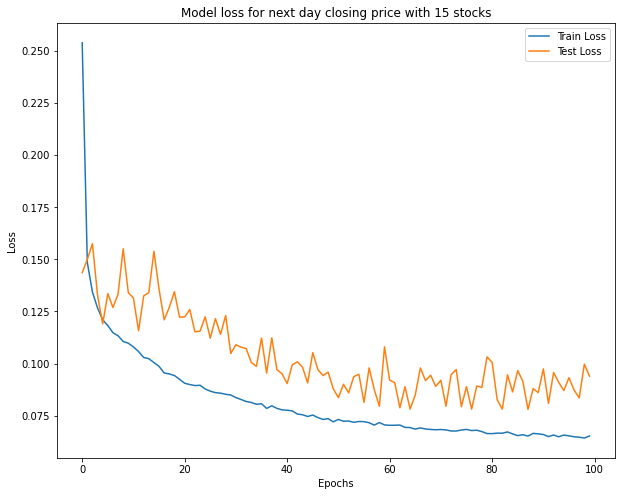

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(History_LSTM.history['loss'], label='Train Loss')
plt.plot(History_LSTM.history['val_loss'], label='Test Loss')
plt.title('Model loss for next day closing price with 15 stocks')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show()

**Saving the model**

In [ ]:
Model_LSTM_CP.save('LSTM_Model_Fifteen_Stocks.h5')